# Machine learning the wavefunction
#### The solution of the 1d Schrödinger equation is learned by a neural network. The training set consists of randomly generated potentials, which are built as superposition of Gaussians.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def gaussian(a, m, sigma, x):
    return a*np.exp(-((x-m)/sigma)**2)

In [292]:
def gaussian_superposition(a, m, sigma, x):
    potential = 0.
    potential = -sum(gaussian(ai, mi, si, x) for ai, mi, si in zip(a,m, sigma))
    return potential


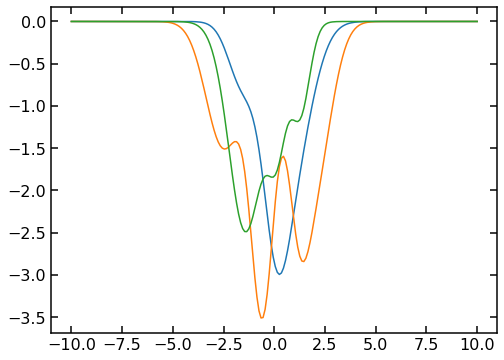

In [293]:
import matplotlib.pyplot as plt
plt.style.use('scientific.mplstyle')
plt.figure(figsize=(8,6))
x = np.linspace(-10,10,200)
n_examples = 3
n_gaussians = 5




for i in range(n_examples):
    a = 2*np.random.random(n_gaussians)
    m = 5*np.random.random(n_gaussians) - 2.5
    sigma = np.random.random(n_gaussians) + .5
    y = gaussian_superposition(a, m, sigma, x)
    plt.plot(x, y)

In [6]:
from _ham import Hamiltonian

In [154]:
# Inititalize Hamiltonian
length = 15
n_steps = 101
ham_random  = Hamiltonian(length,n_steps)

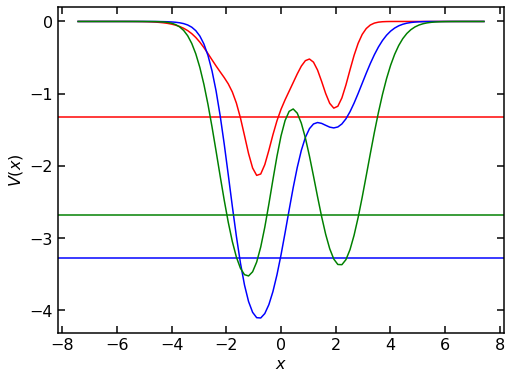

In [272]:
import matplotlib.pyplot as plt
plt.style.use('scientific.mplstyle')
plt.figure(figsize=(8,6))

colors = ['red', 'blue', 'green']

n_data = 3

X_plot = np.zeros((n_data, n_steps))
y_plot = np.zeros(n_data)

n_gaussians = 5

for i in range(n_data):
    a = 2*np.random.random(n_gaussians)
    m = 5*np.random.random(n_gaussians) - 2.5
    sigma = np.random.random(n_gaussians) + .5


    potential = lambda x: gaussian_superposition(a, m, sigma, x)
    ham_random.build_hamiltonian(potential)
    ham_random.diagonalize()

    X_plot[i, :] = potential(ham_random.x_values)
    y_plot[i] = ham_random.eigvals[0]

    plt.axhline(ham_random.eigvals[0], color=colors[i])

    plt.plot(ham_random.x_values, potential(ham_random.x_values),
            color=colors[i])

plt.xlabel('$x$'), plt.ylabel('$V(x)$')
# plt.ylim(0,10)
# plt.xlim(-8,8)

plt.show()


## Create dataset

In [170]:
n_gaussians = 5

n_data = 10000

X_full = np.zeros((n_data, n_steps))
y_full = np.zeros((n_data, n_steps))

for i in range(n_data):
    a = 2*np.random.random(n_gaussians)
    m = 5*np.random.random(n_gaussians) - 2.5
    sigma = np.random.random(n_gaussians) + .5

    potential = lambda x: gaussian_superposition(a, m, sigma, x)
    ham_random.build_hamiltonian(potential)
    ham_random.diagonalize()

    X_full[i, :] = potential(ham_random.x_values)
    y_full[i, :] = ham_random.eigvecs[:,1]**2

/tmp/ipykernel_8250/1128697454.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  y_full[i, :] = ham_random.eigvecs[:,1]**2


In [54]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [171]:
tensor_x = torch.Tensor(X_full)
tensor_y = torch.Tensor(y_full)

train_size = int(.8*len(tensor_x))

norm_x = 10
norm_y = torch.max(tensor_y).item()

dataset_train = TensorDataset(tensor_x[:train_size, :] / norm_x,
                            tensor_y[:train_size] ) 
dataloader_train = DataLoader(dataset_train, batch_size=100) 

dataset_test = TensorDataset(tensor_x[train_size:, :] / norm_x ,
                            tensor_y[train_size:] ) 
dataloader_test = DataLoader(dataset_test) 


### Build and train MLP model

In [178]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MLP(nn.Module):
        def __init__(self, n_steps):
            super().__init__()
            self.layer1 = nn.Linear(n_steps, n_steps)
            self.layer2 = nn.Linear(n_steps, n_steps)
            self.layer3 = nn.Linear(n_steps, n_steps)
            self.layer4 = nn.Linear(n_steps, n_steps)
            self.layer5 = nn.Linear(n_steps, n_steps)
            self.layer6 = nn.Linear(n_steps, n_steps)

        def forward(self, x):
            x = F.relu( self.layer1(x) )
            x = F.relu( self.layer2(x) )
            x = F.relu( self.layer3(x) )
            x = F.relu( self.layer4(x) )
            x = F.relu( self.layer5(x) )
            x = self.layer6(x)
            return x

In [179]:
model = MLP(n_steps)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_function = nn.MSELoss()


In [180]:
all_losses = []
n_epochs = 100
for epoch in range(n_epochs):
    running_loss = 0.0

    for i, (potential, wavefunction) in enumerate(dataloader_train):

        # Forward pass
        outputs = model(potential)
        loss = loss_function(outputs, wavefunction)
        running_loss += loss.item()
        
        # Propagate backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    all_losses.append(running_loss / len(dataloader_train))
    if epoch  % 10 == 0:
            print ('Epoch [{}/{}],  Loss: {:.4f}' 
                .format(epoch+1, n_epochs,all_losses[epoch]))

Epoch [1/100],  Loss: 0.0003
Epoch [11/100],  Loss: 0.0000
Epoch [21/100],  Loss: 0.0000
Epoch [31/100],  Loss: 0.0000
Epoch [41/100],  Loss: 0.0000
Epoch [51/100],  Loss: 0.0000
Epoch [61/100],  Loss: 0.0000
Epoch [71/100],  Loss: 0.0000
Epoch [81/100],  Loss: 0.0000
Epoch [91/100],  Loss: 0.0000


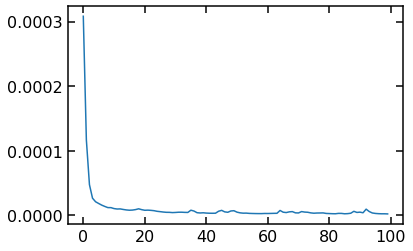

In [181]:
plt.plot(all_losses)

### Evaluate model

In [182]:
mae = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(dataloader_test):
        potential, energy = data
        # calculate outputs by running images through the network
        output = model(potential)
        # the class with the highest energy is what we choose as prediction
        i += 1
        mae += torch.mean(torch.abs(output - energy))



print(f'mae of the network on the test examples: {mae / len(dataloader_test)}')


mae of the network on the test examples: 0.0009324772981926799


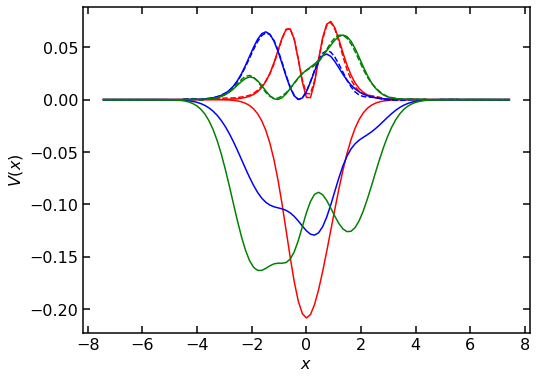

In [218]:
import matplotlib.pyplot as plt
plt.style.use('scientific.mplstyle')
plt.figure(figsize=(8,6))

colors = ['red', 'blue', 'green']
model.float()

for i in range(3):

    with torch.no_grad():
        y_pred = model(tensor_x[train_size + i] / norm_x)
    
    plt.plot(ham_random.x_values, y_pred, color=colors[i], linestyle='dashed')
    plt.plot(ham_random.x_values, tensor_y[train_size + i], color=colors[i] )
    plt.plot(ham_random.x_values, tensor_x[train_size + i]/ 20, color=colors[i] )


plt.xlabel('$x$'), plt.ylabel('$V(x)$')
# plt.ylim(0,10)
# plt.xlim(-8,8)
plt.show()